## GITHUB link:
https://github.com/kommodeskab/Social_assignment1

## Contribution:
| Parts | Andreas Bagge s214630| Gustav Rørhauge s214657| Rasmus Sørensen s214622|
|:---------|:--------:|:--------:|:--------:|
|  Part 1   |  60 %  | 20 %  | 20 % |
|  Part 2   |  20 %   | 20 % | 60 % |
|  Part 3   |  20 %   | 60 % | 20 % |


On the github it looks like it only one who contributed with the majority of the code, but that simply because we worked on it in the classes and kept the final version on one PC. We have all contributed to the assignment.

# Part 1

_First, calculate the probability (p) that makes the expected number of edges in our random network match the actual edge count in the Computational Social Scientists network. Refer to equation 3.2 in your Network Science textbook for guidance. After finding p, figure out the average degree (using the given formula)._
<br>
<br>
We load in the network and calculate _p_ using this formula:
$$p = \frac{2 \cdot|L|}{N \cdot (N - 1)}$$


In [ ]:
import networkx as nx
from networkx.readwrite import json_graph
import json

with open("network.json") as f:
    js_graph = json.load(f)
real_graph = json_graph.node_link_graph(js_graph)

size = len(real_graph.nodes())
num_edges = len(real_graph.edges())
print(f"{size=}, {num_edges=}")
p = (2 * num_edges) / (size * (size - 1))
print(f"{p=}")

size=14205, num_edges=54304
p=0.0005382820709466951


Next up, make a function createRandomGraph that returns a random graph given some number of nodes, N, and a probability that two nodes are connected, p.

In [ ]:
import numpy as np
from tqdm import tqdm
import netwulf as nw

def createRandomGraph(p : float, N : int) -> nx.Graph:
    """
    Create a random graph with N nodes and probability p
    """
    G = nx.Graph()
    for i in range(N):
        G.add_node(i)
    for i in tqdm(range(N)):
        for j in range(i+1, N):
            if np.random.rand() < p:
                G.add_edge(i, j)
    return G

random_graph = createRandomGraph(p, size)
# nw.visualize(random_graph)

100%|██████████| 14205/14205 [00:35<00:00, 403.01it/s] 


(None, None)

As expected, the random graph looks totally random :)
![random graph](pictures/randomgraph.png)

In [ ]:
# check if the random graph is in the supercritical regime
print("In supercitical regime:", p > 1 / size)

In supercitical regime: True


## Questions:
* __What regime does your random network fall into? Is it above or below the critical threshold?__ <br>
The random graph falls into the critical regime. This can be seen by finding that p > 1 / size, which is in the supercritical regime. See the evaluation in the cell above. <br> <br>
* __According to the textbook, what does the network's structure resemble in this regime?__ <br>
from the book: This regime has the most relevance to real systems, as for the first time we have a giant component that looks like a network.  <br> <br>
* __Based on your visualizations, identify the key differences between the actual and the random networks. Explain whether these differences are consistent with theoretical expectations.__ <br>
the real network has many more cliques and is more connected than the random network. This is consistent with the theoretical expectations, as the real network is in the supercritical regime, and the random network is not.




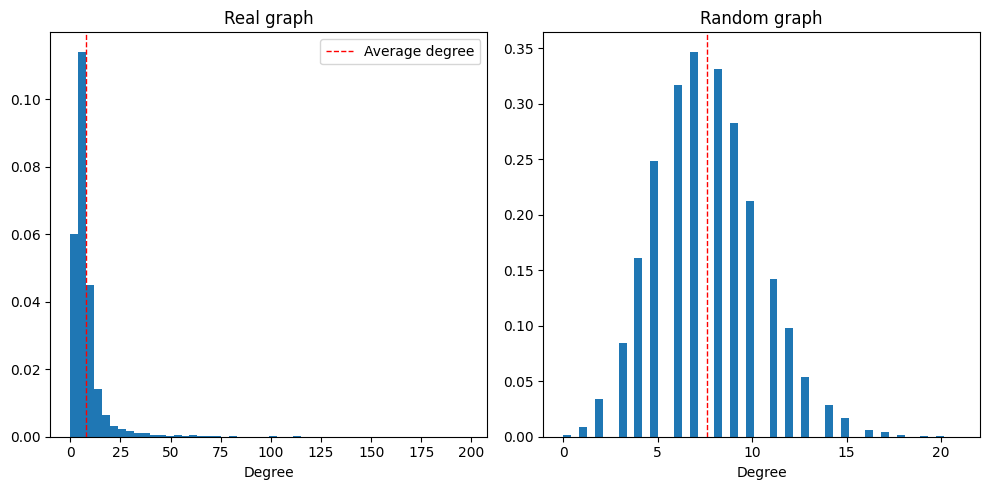

real_avg_degree=7.6457585357268565, random_avg_degree=7.636184442097853


In [ ]:
## find the distribution of the degree of the nodes
import matplotlib.pyplot as plt
degrees_real = [real_graph.degree(n) for n in real_graph.nodes()]
degrees_random = [random_graph.degree(n) for n in random_graph.nodes()]
real_avg_degree = np.mean(degrees_real)
random_avg_degree = np.mean(degrees_random)
max_degree = max(max(degrees_real), max(degrees_random))
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].hist(degrees_real, bins=50, density=True)
axs[1].hist(degrees_random, bins=50, density=True)
axs[0].set_title("Real graph")
axs[1].set_title("Random graph")
axs[0].set_xlabel("Degree")
axs[1].set_xlabel("Degree")

""""
"to better compare" the two plots, we considered the same range for the x-axis
aswell as the y-axis.
But since they have way different number of nodes, the y-axis is not comparable.
"""

# axs[0].set_xlim(0, max_degree)
# axs[1].set_xlim(0, max_degree)
# axs[0].set_ylim(0, 0.4)
# axs[1].set_ylim(0, 0.4)
axs[0].axvline(real_avg_degree, color='r', linestyle='dashed', linewidth=1, label="Average degree")
axs[1].axvline(random_avg_degree, color='r', linestyle='dashed', linewidth=1)
axs[0].legend()
plt.tight_layout()
plt.show()
print(f"{real_avg_degree=}, {random_avg_degree=}")

## Questions:
* __Does the average degree meaningfully represents the network's characteristics, especially in light of the insights gained from exploring heavy-tailed distributions? Discuss its adequacy or limitations in capturing the essence of the network's structural properties.__ <br>
No. As seen above, the networks behave significantly different (one is from the real world, the other is totally random), yet they have the same average degree. This doesnt reflect the fact that the degree distribution of the real network is heavy-tailed meaning that some nodes happen to have a very high degree (this is usually expected from real-life networks). A high degree is improbable under random circumstances, and the random network therefore isn't heavytailed. <br> <br>

* __What differences can you observe between the real and the random distributions? How does the shape of the degree distribution for each network inform us about the network's properties? (max 150 words)__ <br>
As mentioned, the real-life network is heavy-tailed. This means that some nodes will have a very high degree. These nodes corresponds to individuals who have published papers with lots of other authors. This can technically also happen when generating a random graph, but it is very unlikely. However, in the real-world, these collaborations are not random, but a result of a researcher being productive, therefore not constrained by pure probabilities.

## Part 2 - Network Analysis in Computational Social Science


In [ ]:
#imports
import numpy as np
import networkx as nx
import json
import random
import matplotlib.pyplot as plt
from collections import defaultdict
from tqdm import tqdm

with open('network.json') as f:
    js_graph = json.load(f)
    G = nx.readwrite.json_graph.node_link_graph(js_graph)

In [ ]:
###Part 2.1: Assortativity Coefficient
#calculate assortativity coefficient without using built-in function
def calculate_assortativity(graph, attribute : str) -> float:
    nodes_with_attribute = nx.get_node_attributes(graph, 'country_code')
    countries = list(set(nodes_with_attribute.values()))
    country_matrix = defaultdict(lambda: defaultdict(int))

    for (u, v) in graph.edges():
        country_u = nodes_with_attribute[u]
        country_v = nodes_with_attribute[v]
        country_matrix[country_u][country_v] += 1
        country_matrix[country_v][country_u] += 1

    country_matrix = np.array([[country_matrix[country_u][country_v] for country_v in countries] for country_u in countries])
    country_matrix = country_matrix / country_matrix.sum()

    ai = np.sum(country_matrix, axis=1)
    bi = np.sum(country_matrix, axis=0)
    eii = np.trace(country_matrix)
    assortativity = (eii - np.dot(ai, bi))/(1 - np.dot(ai, bi))
    return assortativity

In [ ]:
###Part 2.2: Configuration model
def double_edge_swap(graph, num_swaps=None):
    #Create a copy of the graph
    H = graph.copy()
    if num_swaps is None:
        num_swaps = H.number_of_edges() * 10
    edges = list(H.edges())
    n = len(edges)
    for _ in range(num_swaps):
        while True:
            #Select two edges
            i, j = random.sample(range(n), 2)
            e1 = edges[i]
            e2 = edges[j]
            #Flip the direction of e1 with a 50% chance
            if random.random() < 0.5:
                e1 = (e1[1], e1[0])
            #Avoid self-loops and multi-edges
            if e1[0] != e2[1] and e1[1] != e2[0] and not H.has_edge(e1[0], e2[1]) and not H.has_edge(e2[0], e1[1]):
                #Create new edges e1' and e2'
                e1_new = (e1[0], e2[1])
                e2_new = (e2[0], e1[1])
                break
        #Swap edges
        H.remove_edge(*e1)
        H.remove_edge(*e2)
        H.add_edge(*e1_new)
        H.add_edge(*e2_new)
        #Update
        edges[i] = e1_new
        edges[j] = e2_new
    return H

for i in tqdm(range(1)):
    random_network = double_edge_swap(G)
    assert sorted([d for n, d in G.degree()]) == sorted([d for n, d in random_network.degree()])
    print("Degree of nodes in the original network and the new 'randomized' version of the network are the same.")

list_of_graphs = []
for i in tqdm(range(100)):
    random_network = double_edge_swap(G)
    list_of_graphs.append(random_network)

In [ ]:
###Part 2.3: Plot the histogram of assortativity coefficients and compare with the original assortativity coefficient
#Find the assortativity coefficients of the randomized networks
assortativity_Coefficient_list = []
for i in tqdm(list_of_graphs):
    assortativity_Coefficient_list.append(calculate_assortativity(i, 'country_code'))
print(assortativity_Coefficient_list)


In [ ]:
#Plot the histogram of assortativity coefficients
plt.hist(assortativity_Coefficient_list, bins = 20)
x=calculate_assortativity(G, "country_code")
plt.axvline(x, color='r', linestyle='dashed', linewidth=1)

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(0.05, 0.95, f'Red Line: Original (x={x:.4f})',
         transform=plt.gca().transAxes, fontsize=10, verticalalignment='top', bbox=props)
plt.xlabel('Assortativity Coefficient')
plt.ylabel('Frequency')
plt.title('Histogram of Assortativity Coefficients')
plt.show()

### Comments
From this histogram we can say that the original network shows a strong tendency to connect scientists from the same nation. This aligns with our expectations because it's probably more people going to work at universities close to where they live.

In [ ]:
###Part 2.4: Assortativity by Degree
#We are using mark newman formula for assortativity coefficient by degree
def calculate_assortativity_by_degree(graph):
    e = graph.number_of_edges()
    j_k_sum = 0
    j_plus_k_sum = 0
    j2_plus_k2_sum = 0

    for i, j in graph.edges():
        j_degree = graph.degree(i)
        k_degree = graph.degree(j)

        j_k_sum += j_degree * k_degree
        j_plus_k_sum += j_degree + k_degree
        j2_plus_k2_sum += j_degree**2 + k_degree**2

    r = ((j_k_sum / e) - (j_plus_k_sum / (2 * e)) ** 2)/((j2_plus_k2_sum / (2 * e)) - (j_plus_k_sum / (2 * e)) ** 2)

    if r == 0:
        return 0
    return r

In [ ]:
#Calculate assortativity by degree for the randomized networks
assortativity_by_degree_list = []
for i in tqdm(list_of_graphs ):
    assortativity_by_degree_list.append(calculate_assortativity_by_degree(i))
print(assortativity_by_degree_list)

In [ ]:
#Plot the histogram of assortativity coefficients by degree
print(assortativity_by_degree_list)
plt.hist(assortativity_by_degree_list, bins = 20)
x_2=calculate_assortativity_by_degree(G)
plt.axvline(x_2, color='r', linestyle='dashed', linewidth=1)

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(0.05, 0.95, f'Red Line: Original (x={x_2:.4f})',
         transform=plt.gca().transAxes, fontsize=10, verticalalignment='top', bbox=props)
plt.xlabel('Assortativity Coefficient by degree')
plt.ylabel('Frequency')
plt.title('Histogram of Assortativity Coefficients degree')
plt.show()

### Comments
Here we see that our original is disassortative, meaning nodes tend to connect to others with dissimilar degrees. The random generated ones are close to zero which we expected since it is random. For the original one it show sign on non-randomness and mixing.

### Part 2.5: Reflection questions (max 250 words for the 3 questions)

7. Assortativity by degree. Were the results of the degree assortativity in line with your expectations? Why or why not?

This somewhat aligns with what we expected since researcher cooperate with other researcher to cover different topics. And what we see on the histogram is that our original network connects with some that are not directly similar. If we look at the distribution of the randomly generated networks, they are centered around zero, which is a good sign due to it being free from bias. Furthermore, this aligns with theoretical expectations because random networks typically do not exhibit strong assortative or disassortative mixing patterns. And therefore, we can conclude that the original one consists of some non-randomness.

8. Edge flipping. In the process of implementing the configuration model, you were instructed to flip the edges (e.g., changing e_1 from (u,v) to (v,u)) 50% of the time. Why do you think this step is included?

This step was used, since we wanted to create a truly random graph. If we hadn’t included this some bias from the original graph would have been preserved in the process and would lead to bias. This is due to the importance of what the direction tells us about the dynamics of the social graph. Like some person being super connected and some not, otherwise those could have the same behavior in the copy.

9. Distribution of assortativity in random networks. Describe the distribution of degree assortativity values you observed for the random networks. Was the distribution pattern expected? Discuss how the nature of random network generation (specifically, the configuration model and edge flipping) might influence this distribution and whether it aligns with theoretical expectations.

The distribution is expected to have associativity coefficients closer to zero due to have minimal assortative by degree because connections are made randomly. Furthermore, this explain why the distribution is centered close to zero. Of cause would some of the random networks have more connection and pattern then others, and therefore we get a distribution. This reinforce what we said in section 7 above about the difference on graphs with connections and the sign of non-randomness, which most real life networks have.

In [ ]:
### Exercise 2: Centrality Measures
#Find the 5 most central scientists according to the closeness centrality measure
closeness_centrality = nx.closeness_centrality(G)
sorted_closeness_centrality = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)
top_5_closeness = sorted_closeness_centrality[:5]
for node, closeness in top_5_closeness:
    print(f"{G.nodes[node]['display_name']} has a closeness centrality of {closeness:.4f}")

### What role do you imagine scientists with high closeness centrality play?
We think that it measures how quickly information can spread from a given node to all other nodes due to closeness centrality being the distance to other nodes. This mean if it is in the right place in the network it can quickly cummunicate.

In [ ]:
#Find the 5 most central scientists according to eigenvector centrality.
eigenvector_centrality = nx.eigenvector_centrality(G)
sorted_eigenvector_centrality = sorted(eigenvector_centrality.items(), key=lambda x: x[1], reverse=True)
top_5_eigenvector = sorted_eigenvector_centrality[:5]
for node, eigenvector in top_5_eigenvector:
    print(f"{G.nodes[node]['display_name']} has an eigenvector centrality of {eigenvector:.4f}")

In [ ]:
#Plot the closeness centrality of nodes vs their degree.
degrees = dict(G.degree())

plt.scatter(degrees.values(), closeness_centrality.values(), alpha=0.5)
plt.xlabel('Degree')
plt.ylabel('Closeness Centrality')
plt.title('Closeness Centrality vs Degree')
plt.show()

### Comments on graph
Closeness centrality: This indicates how close a node is to all other nodes in the network.

This plot lines with our expectation, in that way where scientists with a higher degree also tend to have higher closeness centrality. However, there is a wide spread in the data, especially among nodes with a higher degree, suggesting that having many connections does not always guarantee a proportionally higher closeness to all other nodes.

In [ ]:
#eigenvector centrality instead of closeness centrality
# Create a scatter plot
plt.scatter(degrees.values(), eigenvector_centrality.values(), alpha=0.5)
plt.xlabel('Degree')
plt.ylabel('Eigenvector Centrality')
plt.title('Eigenvector Centrality vs Degree')
plt.show()

### Comments on graph
What is eigenvector centrality: Eigenvector centrality considers both the quantity and quality of connections.

This plot does show sign of expection, which is higer degree means higer eigenvector centrlity. But this data isn't linear as we expected, which means that some nodes with high degree isn't connected to influential once. What we can say is that there exist some connection between some well-connected nodes.


## Part 3 - Words that characterize Computational Social Science communities

* __Explain in your own words the point of TF-IDF.
What does TF stand for?
What does IDF stand for?__

 TF stands for term frequency, this is the number of times a word appears in a document. IDF stands for inverse document frequency, this is the number of times a word appears across the documents in the corpus. A low IDF means that the word could be important in a particular document, where a high IDF means that the word is commonly used across all documents in the corpus. TF-IDF is the product of TF and IDF.

### Now, we want to find out which words are important for each community, so we're going to create several *large documents, one for each community*. Each document includes all the tokens of abstracts written by members of a given community.
* __Consider a community c.__
* __Find all the abstracts of papers written by a member of community c.__
* __Create a long array that stores all the abstract tokens.__
* __Repeat for all the communities.__



In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/MyDrive/comsocsci')
print(os.getcwd())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/comsocsci


In [ ]:
import pandas as pd
import numpy as np
import networkx as nx

# load the data
authors = pd.read_csv("final_authors.csv")
final_papers = pd.read_csv("final_papers.csv")
abstracts_tokenized = pd.read_csv("abstracts_with_tokens.csv")

# preprocess
abstracts_tokenized["tokens_no_significant_bigrams"] = abstracts_tokenized["tokens_no_significant_bigrams"].apply(eval)
final_papers["author_ids"] = final_papers["author_ids"].apply(eval)

In [ ]:
# load author network file
from networkx.readwrite import json_graph
import json

with open("network.json") as f:
    js_graph = json.load(f)

graph = json_graph.node_link_graph(js_graph)
degree_dict = dict(graph.degree())
print(degree_dict)

{'https://openalex.org/A5032539868': 10, 'https://openalex.org/A5080298742': 10, 'https://openalex.org/A5076015541': 5, 'https://openalex.org/A5020199695': 5, 'https://openalex.org/A5059871346': 5, 'https://openalex.org/A5014662127': 21, 'https://openalex.org/A5024396732': 9, 'https://openalex.org/A5079596102': 8, 'https://openalex.org/A5002020728': 20, 'https://openalex.org/A5041066777': 8, 'https://openalex.org/A5015478086': 9, 'https://openalex.org/A5074995400': 4, 'https://openalex.org/A5078253058': 4, 'https://openalex.org/A5075956753': 7, 'https://openalex.org/A5067118505': 17, 'https://openalex.org/A5015080044': 7, 'https://openalex.org/A5031780796': 3, 'https://openalex.org/A5065975854': 3, 'https://openalex.org/A5059559070': 3, 'https://openalex.org/A5058488443': 3, 'https://openalex.org/A5067419282': 4, 'https://openalex.org/A5073806709': 3, 'https://openalex.org/A5031078248': 4, 'https://openalex.org/A5037198041': 2, 'https://openalex.org/A5033721332': 1, 'https://openalex.o

In [ ]:
abstracts_tokenized = pd.read_csv("abstracts_with_tokens.csv")
abstracts_tokenized["tokens_no_significant_bigrams"] = abstracts_tokenized["tokens_no_significant_bigrams"].apply(eval)
final_papers = pd.read_csv("final_papers.csv")
final_papers["author_ids"] = final_papers["author_ids"].apply(eval)

In [ ]:
# create dataframe, using explode for efficiency in the coming tasks
df1 = abstracts_tokenized[["id", "tokens_no_significant_bigrams"]]
df2 = final_papers[["id", "author_ids"]]
df3 = pd.merge(df1, df2)
df3_exploded = df3.explode("author_ids", ignore_index=True)
df3_exploded

id  \
0       https://openalex.org/W2962772482   
1       https://openalex.org/W2962772482   
2       https://openalex.org/W2962772482   
3       https://openalex.org/W2962772482   
4       https://openalex.org/W2962772482   
...                                  ...   
531528  https://openalex.org/W2566179265   
531529  https://openalex.org/W2057789237   
531530  https://openalex.org/W2324891458   
531531  https://openalex.org/W1588895954   
531532  https://openalex.org/W2041555325   

                            tokens_no_significant_bigrams  \
0       [recent_years, many, accurate, decision_suppor...   
1       [recent_years, many, accurate, decision_suppor...   
2       [recent_years, many, accurate, decision_suppor...   
3       [recent_years, many, accurate, decision_suppor...   
4       [recent_years, many, accurate, decision_suppor...   
...                                                   ...   
531528  [abstract_many, varieties, romance, show_one, ...   
531529  [eponyms, known, praise, leading, scientists, ...   
531530                                                 []   
531531                                                 []   
531532  [although, past_research, established, utilita...   

                              author_ids  
0       https://openalex.org/A5091251187  
1       https://openalex.org/A5003777693  
2       https://openalex.org/A5071524745  
3       https://openalex.org/A5023007469  
4       https://openalex.org/A5024505700  
...                                  ...  
531528  https://openalex.org/A5083969011  
531529  https://openalex.org/A5047618628  
531530  https://openalex.org/A5071547862  
531531  https://openalex.org/A5051226686  
531532  https://openalex.org/A5050902528  

[531533 rows x 3 columns]

In [ ]:
from community import community_louvain
from collections import defaultdict

partition = community_louvain.best_partition(graph)
partition_dict = defaultdict(lambda: -1)
for k, v in partition.items():
    partition_dict[k] = v
df3_exploded["community"] = df3_exploded["author_ids"].apply(lambda x: partition_dict[x])

In [ ]:
# define function for combining tokens
def combine_tokens(group):
    all_tokens = []
    for tokens in group:
        all_tokens.extend(tokens)
    return all_tokens

# apply the combine_tokens function after grouping by 'Community'
result_df = df3_exploded.groupby('community')['tokens_no_significant_bigrams'].apply(combine_tokens).reset_index()
community_tokens = dict(zip(result_df["community"], result_df["tokens_no_significant_bigrams"]))
result_df

community                      tokens_no_significant_bigrams
0           -1  [recent_years, many, accurate, decision_suppor...
1            0  [understanding_brain, connectivity, one_import...
2            1  [half_century, television, dominant, pervasive...
3            3  [important, geographic_variation, occurrence, ...
4            4  [exp, three, young, chimpanzees, trained, matc...
..         ...                                                ...
639       1097  [political, debates, bearing, ideological, ref...
640       1098  [coordination, essential, technique, cooperati...
641       1100  [introducing, information_technology, organiza...
642       1101  [crime, perception, safety, two, intertwined, ...
643       1102  [abstract, citizen_science, practices, differe...

[644 rows x 2 columns]

In [ ]:
from tqdm import tqdm
from collections import Counter

# Define functions

def top_n_terms(list_of_tokens, n):
    """
    Find the top n most common tokens in a list of tokens
    """
    counter = Counter(list_of_tokens)
    return counter.most_common(n)

def tf(term, document):
    return document.count(term) / len(document)

# Added 1 in numerator and denominator of formula.
def idf(term, documents):
    documents = [set(document) for document in documents]
    return np.log((len(documents) + 1) / (1 + sum([1 for document in documents if term in document])))


In [ ]:
## get the top 5 biggest communities
## using the partition_dict to get the size of each community
community_size = defaultdict(lambda: 0)
for k, v in partition.items():
    community_size[v] += 1
community_size = dict(community_size)
sorted_community_size = sorted(community_size.items(), key=lambda x: x[1], reverse=True)
top_5_biggest_communities = sorted_community_size[:5]
top_5_biggest_communities = [x[0] for x in top_5_biggest_communities]
print(f"Top 5 biggest communities: {top_5_biggest_communities}")

# top 3 names of authors in each community
def get_top_3_authors(group):
    author_count = defaultdict(lambda: 0)
    for author in group:
        author_count[author] += 1
    author_count = dict(author_count)
    sorted_author_count = sorted(author_count.items(), key=lambda x: x[1], reverse=True)
    top_3_authors = sorted_author_count[:3]
    top_3_authors = [x[0] for x in top_3_authors]
    return top_3_authors

# Apply the get_top_3_authors function after grouping by 'Community'
top_3_authors_df = df3_exploded.groupby('community')['author_ids'].apply(get_top_3_authors).reset_index()
## make a dictionary of community and top 3 authors, using their display_name
community_top_3_authors = dict(zip(top_3_authors_df["community"], top_3_authors_df["author_ids"]))


Top 5 biggest communities: [25, 3, 64, 24, 10]
     community                                         author_ids
0           -1  [https://openalex.org/A5086852785, https://ope...
1            0  [https://openalex.org/A5027706684, https://ope...
2            1  [https://openalex.org/A5064827570, https://ope...
3            3  [https://openalex.org/A5008831111, https://ope...
4            4  [https://openalex.org/A5031078248, https://ope...
..         ...                                                ...
639       1097                 [https://openalex.org/A5009316832]
640       1098                 [https://openalex.org/A5082205147]
641       1100                 [https://openalex.org/A5038233956]
642       1101                 [https://openalex.org/A5090329397]
643       1102                 [https://openalex.org/A5093039163]

[644 rows x 2 columns]


In [ ]:
from collections import defaultdict

community_size = defaultdict(lambda: 0)
for k, v in partition.items():
    community_size[v] += 1
community_size = dict(community_size)
sorted_community_size = sorted(community_size.items(), key=lambda x: x[1], reverse=True)
top_9_biggest_communities = sorted_community_size[:9]
top_9_biggest_communities = [x[0] for x in top_9_biggest_communities]
top_9_biggest_communities

documents = [community_tokens[community] for community in top_9_biggest_communities]
all_tokens = []
for document in documents:
    all_tokens.extend(document)
all_tokens = list(set(all_tokens))

print(f"first 10 tokens: {all_tokens[:10]}")
#idfs = [idf(token, documents) for token in all_tokens]

first 10 tokens: ['dispatching', 'state_research', 'valladolid', 'cumming', 'playa', 'sign', 'ml_models', 'headed', 'ory', 'frowned']


In [ ]:
#We're ready to calculate TF-IDF. Do that for the top 9 communities (by number of authors).
top_9_TF_IDF = {}
for community in top_9_biggest_communities:
    top_9_TF_IDF[community] = {}
    # make progress bar that updates on same line
    for term in all_tokens:
        top_9_TF_IDF[community][term] = tf(term, community_tokens[community]) * idf(term, documents)
print(top_9_TF_IDF)



* __What are the similarities and differences between the communities?__ <br>
An interesting similiarity among the communities is that the most common words are words often seen in scientific literature, such as "performance", "analysis", "using" and "data". This is expected, as the communities are research-oriented. It also seems that most of the top 5 communities put a lot of emphasis on describing their setup, with words such as "model", "design" and "system".
Dissimilarities are clear from the domain from which the words come from. Community 1 seems to be more focused on language and text, with words such as "speech", "prosodic", "listeners" and "words", whereas community 3 is clearly more focused on robotics, with words such as "robot", "robots" and  "interaction".

* __Next, we calculate IDF for every word. What base logarithm did you use? Is that important?__ <br>
We used the natural logarithm, and it is not important for the result which base we use since it is a monotonous function. For maximal efficiency the base2 logarithm might be preferable, since it can be represented using only 1 bit.

## We're ready to calculate TF-IDF. Do that for the top 9 communities (by number of authors). Then for each community:


* __List the 10 top TF words__
* __List the 10 top TF-IDF words__
* __List the top 3 authors (by degree)__
* __Are these 10 words more descriptive of the community? If yes, what is it about IDF that makes the words more informative?__
- Yes, the top 10 words by TF-IDF are more descriptive of the community. IDF makes the words more informative by penalizing words that appear in many documents. This is because words that appear in many documents are less informative than words that appear in fewer documents. This is why the top 10 words by TF-IDF are more descriptive of the community than the top 10 words by TF.

In [ ]:
# for each community, list the top 10 words by TF
top_10_TF = {}
for community in top_9_biggest_communities:
    top_10_TF[community] = top_n_terms(community_tokens[community],10)
print(top_10_TF)

# for each community, list the top 10 words by TF-IDF
top_10_TF_IDF = {}
for community in top_9_biggest_communities:
    top_10_TF_IDF[community] = sorted(top_9_TF_IDF[community].items(), key=lambda x: x[1], reverse=True)[:10]
print(top_10_TF_IDF.keys())



## Exercise 2: The Wordcloud. It's time to visualize our results!


* __What can you conclude on the different sub-communities in Computational Social Science?__ <br>
We can conclude that the sub-communities are related indeed quite different. They focus on many different topics. For example the biggest community in the top 9 has to do with linguistics, and the smallest has to do with social media. This is evident from the wordclouds of the sub-communities. As when we analysed the most frequent words in the earlier task, we see there is a community concerning robotics as well as a community concerning autonomous driving.

* __Look up online the top author in each community. In light of your search, do your results make sense?__ <br>
The top author of the first community, the one we determined has to do with linguistics/NLP is William Yang Wang. His tags on google scholar include "Natural Language Processing", so this makes sense.
<br>
The second author is Thomas S. Huang, his google scholar tags include image processing and computer vision. This matches the wordcloud of the community.
<br>
The third author is Cynthia Breazeal, her tags are "Human-Computer interaction" and "Social Robotics". This matches our findings from the wordcloud of the community.
<br>
The fourth is Dorret Boomsma. She has multiple published papers about biology and medical research. This also matches.
<br>
The fifth is Neville A. Stanton. His tags are "Human Factors", "Sociotechnical System" and "Accidents", this corresponds well with the wordcloud theme.
<br>
The sixth is Robin Dunbar. With publications regarding human networking, brain size and individuality, this fits the wordcloud theme.
<br>
The seventh is Joshua B. Tenenbaum. His tags are "Machine Learning" "Computational Neuroscience". This matches the wordcloud of the community.
<br>
The eigth is Munmun De Choudhury. Her tags are "Computational Social Science", "Mental Health" and "Language". This matches the theme of the wordcloud that contains words such as "online", "users" and "behavior".
<br>
The ninth is Lyle H. Ungar. With some of his more recent publications being on the topic of Twitter and social media, this also matches.

<br> Overall we can conclude that our results make sense.




In [ ]:
# Function to get top 3 authors display name to be used in wordcloud plot.
def get_top_3_authors_display_name(group):
    top_3_authors = group
    top_3_authors_display_name = []
    for author in top_3_authors:
        display_name = authors[authors["id"] == author]["display_name"].values[0]
        top_3_authors_display_name.append(display_name)
    return top_3_authors_display_name

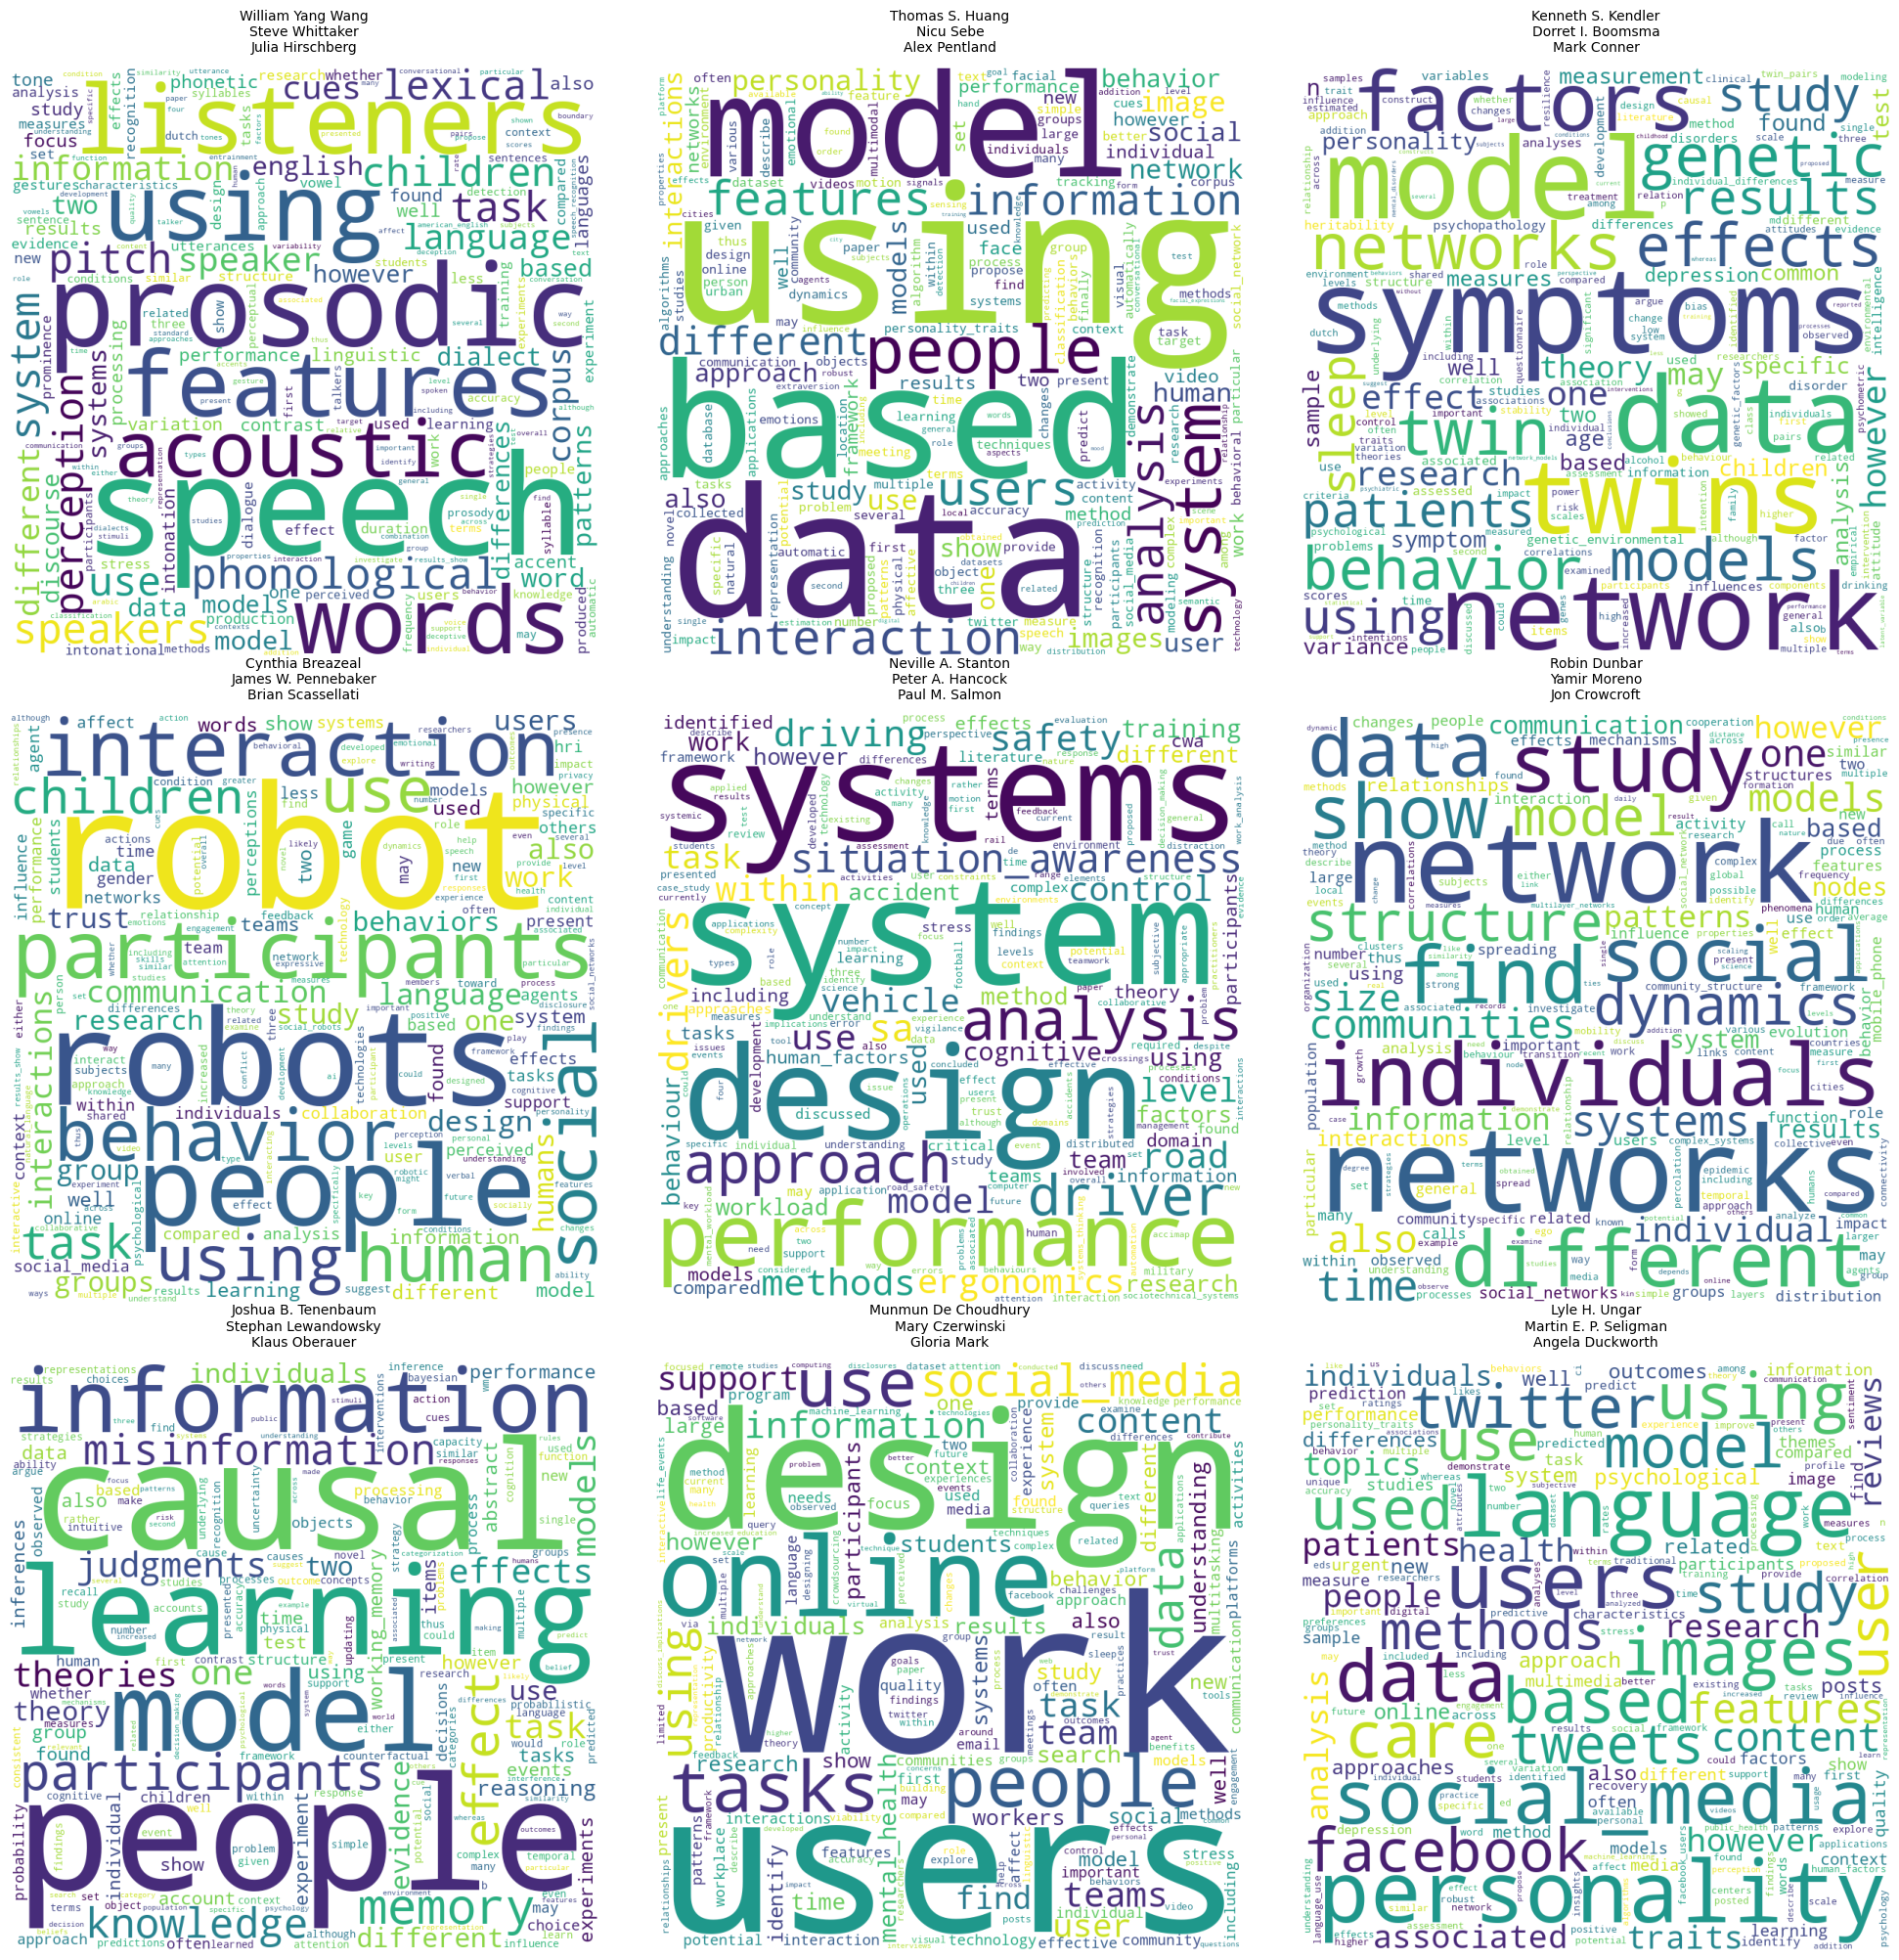

In [ ]:

from wordcloud import WordCloud
import matplotlib.pyplot as plt

# create word-cloud for each community, since there are 9 communities, it should be 3x3.
# the size of the word is proportional to the TF. The top 3 authors from each community are also displayed above the plot.
fig, axs = plt.subplots(3, 3, figsize=(20, 20))
for i, community in enumerate(top_9_biggest_communities):
    ax = axs[i // 3, i % 3]
    word_freq = top_n_terms(community_tokens[community],len(community_tokens[community]))
    wordcloud = WordCloud(width=800, height=800, background_color='white').generate_from_frequencies(dict(word_freq))
    ax.imshow(wordcloud)
    ax.axis("off")

    top_3_authors_display_name = get_top_3_authors_display_name(community_top_3_authors[community])
    top_3_authors_display_name = "\n".join(top_3_authors_display_name)
    ax.text(0.5, 1.1, top_3_authors_display_name, horizontalalignment='center', verticalalignment='top', transform=ax.transAxes)

plt.tight_layout()
plt.show()





